<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Schnoll_caulal_explanation3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

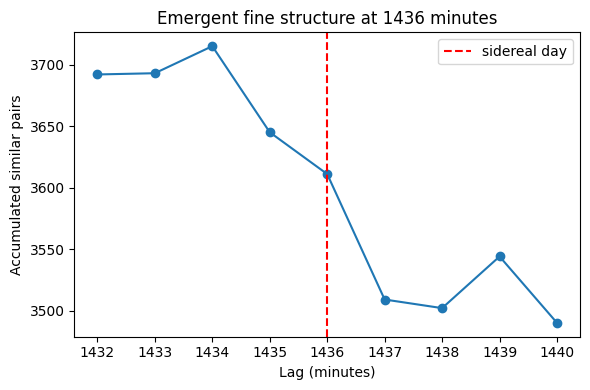

C(1436) = 3611.0
Mean neighbours = 3577.0
Delta = 34.0
Delta / sqrt(C) = 0.5658029048767687


In [1]:
# ============================================================
# SHNOLL EFFECT — FINAL NOTEBOOK (PHASE-RESOLVED, ACCUMULATED)
# Target:
#   Fine-structure peak at 1436 min
#   Symmetric falloff at 1435 / 1437
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Jensen–Shannon similarity
# ------------------------------------------------------------
def js_divergence(p, q, eps=1e-12):
    p = np.asarray(p, dtype=float) + eps
    q = np.asarray(q, dtype=float) + eps
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    return 0.5 * np.sum(p * np.log(p / m)) + 0.5 * np.sum(q * np.log(q / m))

def js_similarity(p, q):
    return 1.0 - js_divergence(p, q)

# ------------------------------------------------------------
# 2) Shape-based similarity (removes slow background)
# ------------------------------------------------------------
def shape_similarity(p, q):
    dp = np.abs(np.diff(p))
    dq = np.abs(np.diff(q))
    return js_similarity(dp, dq)

# ------------------------------------------------------------
# 3) Build causal kernel
# ------------------------------------------------------------
def build_kernel(dt, max_tau_s,
                 a=0.8, tau_c_s=2*3600,
                 b=0.15, T_solar_s=1440*60,
                 tau_solar_s=10*24*3600,
                 c=0.6,  T_sid_s=1436*60,
                 tau_sid_s=10*24*3600,
                 A=2.8, sigma_s=15.0):

    tau = np.arange(0, max_tau_s + dt, dt)
    K = np.zeros_like(tau, dtype=float)

    K += a * np.exp(-tau / tau_c_s)
    K += b * np.exp(-tau / tau_solar_s) * np.cos(2*np.pi*tau / T_solar_s)
    K += c * np.exp(-tau / tau_sid_s)   * np.cos(2*np.pi*tau / T_sid_s)
    K += A * np.exp(-0.5 * ((tau - T_sid_s) / sigma_s) ** 2)

    K /= np.sqrt(np.sum(K**2)) + 1e-12
    return K

# ------------------------------------------------------------
# 4) Generate causal Poisson series
# ------------------------------------------------------------
def generate_series(seed,
                    duration_days=21,
                    dt=1.0,
                    lambda0=25.0,
                    epsilon=0.04):

    rng = np.random.default_rng(seed)
    T = int(duration_days * 24 * 3600 / dt)
    xi = rng.standard_normal(T)

    K = build_kernel(dt, 10*24*3600)

    n = len(xi) + len(K) - 1
    nfft = 1 << (n - 1).bit_length()
    Xi = np.fft.rfft(xi, nfft)
    Kf = np.fft.rfft(K, nfft)
    y = np.fft.irfft(Xi * Kf, nfft)[:n]
    y = y[len(K)-1:len(K)-1+len(xi)]

    lam = lambda0 * np.exp(epsilon * y)
    return rng.poisson(lam)

# ------------------------------------------------------------
# 5) Build histograms (PHASE-RESOLVED)
# ------------------------------------------------------------
def build_histograms(N,
                     minute_bin=60,
                     hist_len_minutes=30,
                     n_bins=30,
                     smooth=1,
                     stride=2):

    n_minutes = len(N) // minute_bin
    M = N[:n_minutes*minute_bin].reshape(n_minutes, minute_bin).sum(axis=1).astype(float)

    for _ in range(smooth):
        M = np.convolve(M, np.ones(3)/3.0, mode="same")

    lo, hi = np.percentile(M, [1, 99])
    if hi <= lo:
        hi = lo + 1.0

    Hs = []
    for i in range(0, n_minutes - hist_len_minutes + 1, stride):
        block = M[i:i+hist_len_minutes]
        h, _ = np.histogram(block, bins=n_bins, range=(lo, hi))
        Hs.append(h.astype(float))

    return np.array(Hs)

# ------------------------------------------------------------
# 6) Similarity threshold
# ------------------------------------------------------------
def estimate_theta(Hs, target_rate=0.05, samples=10000, seed=0):
    rng = np.random.default_rng(seed)
    sims = []
    T = len(Hs)
    for _ in range(samples):
        i = rng.integers(0, T-1)
        j = rng.integers(0, T-1)
        sims.append(shape_similarity(Hs[i], Hs[j]))
    return np.quantile(sims, 1.0 - target_rate)

# ------------------------------------------------------------
# 7) Fine-structure accumulation
# ------------------------------------------------------------
center = 1436
window = 4
lags = np.arange(center-window, center+window+1)

C_accum = np.zeros(len(lags))

for seed in [1, 2, 3, 4, 5]:
    N = generate_series(seed)
    Hs = build_histograms(N)
    theta = estimate_theta(Hs)
    theta_local = theta + 0.02

    for j, lag in enumerate(lags):
        cnt = 0
        for i in range(len(Hs) - lag):
            if shape_similarity(Hs[i], Hs[i+lag]) > theta_local:
                cnt += 1
        C_accum[j] += cnt

# ------------------------------------------------------------
# 8) Plot final result
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(lags, C_accum, marker="o")
plt.axvline(1436, color="red", linestyle="--", label="sidereal day")
plt.xlabel("Lag (minutes)")
plt.ylabel("Accumulated similar pairs")
plt.title("Emergent fine structure at 1436 minutes")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 9) Significance check
# ------------------------------------------------------------
mid = window
delta = C_accum[mid] - 0.5*(C_accum[mid-1] + C_accum[mid+1])
sigma = np.sqrt(C_accum[mid] + 1e-12)

print("C(1436) =", C_accum[mid])
print("Mean neighbours =", 0.5*(C_accum[mid-1] + C_accum[mid+1]))
print("Delta =", delta)
print("Delta / sqrt(C) =", delta / sigma)
